In [ ]:
import matplotlib.pyplot as plt
import random
import os
import pandas as pd
import seaborn as sns
from keras import backend as K
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Bidirectional, Dense, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Input, Dense, MaxPool2D, Conv2D, BatchNormalization, Flatten,Dropout, MaxPooling2D,UpSampling2D
from keras.models import Model, load_model
from keras import regularizers, models
from scipy.signal import medfilt
from scipy.ndimage import gaussian_filter1d
import numpy as np
from numpy import array
import time

In [ ]:
df = pd.read_csv("/content/sample_data/climate_moscow.csv", on_bad_lines='skip', sep='\t') # считываем из csv файла данные
df.drop(['datetime','Snow'], axis= 1 , inplace= True )
#удаление пустых значений даты
df = df.dropna(subset='Date time')
#сортировка даты
df = df.sort_values('Date time')
#преобразование типа
df['Date time'] = pd.to_datetime(df['Date time'])
#установка в качестве индекса
df.set_index('Date time', inplace=True)
df.head()

,Name,Maximum Temperature,Minimum Temperature,Temperature,Wind Chill,Heat Index,Precipitation,Snow Depth,Wind Speed,Wind Direction,Wind Gust,Visibility,Cloud Cover,Relative Humidity,Conditions,year,month,day,unix
Date time,,,,,,,,,,,,,,,,,,,
1971-01-01,"Москва, Центральный федеральный округ, Россия",-3.8,-7.8,-6.9,-15.7,NaN,0.0,NaN,29.5,260.00,NaN,7.4,92.5,75.56,Overcast,1971.0,1.0,1.0,31536000
1973-01-01,"Москва, Центральный федеральный округ, Россия",3.7,-0.8,0.6,-7.0,NaN,0.0,NaN,32.4,NaN,NaN,10.0,19.1,40.97,Clear,1973.0,1.0,1.0,94694400
1974-01-01,"Москва, Центральный федеральный округ, Россия",0.1,-0.5,0.0,-6.5,NaN,0.0,NaN,25.2,255.53,NaN,9.7,85.1,80.28,Overcast,1974.0,1.0,1.0,126230400
1975-01-01,"Москва, Центральный федеральный округ, Россия",-3.5,-5.9,-5.0,-11.6,NaN,0.8,95.0,16.0,296.91,NaN,9.8,97.5,83.10,"Rain, Overcast",1975.0,1.0,1.0,157766400
1976-01-01,"Москва, Центральный федеральный округ, Россия",2.1,0.0,0.9,-6.0,NaN,3.0,23.0,43.2,226.14,NaN,6.4,73.9,87.49,"Rain, Partially cloudy",1976.0,1.0,1.0,189302400


In [ ]:
#удаление пропусков
list_c = df.columns.values.tolist()
for i in list_c:
  if(i!='Name' and i!='Conditions'):
    df[i] = df[i]. fillna(df[i].mean())
df = df.dropna()
df.isnull().sum()

Name                   0
Maximum Temperature    0
Minimum Temperature    0
Temperature            0
Wind Chill             0
Heat Index             0
Precipitation          0
Snow Depth             0
Wind Speed             0
Wind Direction         0
Wind Gust              0
Visibility             0
Cloud Cover            0
Relative Humidity      0
Conditions             0
year                   0
month                  0
day                    0
unix                   0
dtype: int64

In [ ]:
#воспроизводимость результатов
from numpy.random import seed
seed(1)
tf.random.set_seed(1)

In [ ]:
# Медианная фильтрация
df['Temperature'] = medfilt(df['Temperature'],3)
# Гауссов фильтр
df['Temperature'] = gaussian_filter1d(df['Temperature'],1.2)

# Разделение данных перед обучением

In [ ]:
temp_col = 'Temperature'
temp_col = df[temp_col].values.reshape(-1, 1)

# Нормализация данных
scaler = MinMaxScaler()
target_data = scaler.fit_transform(temp_col)

# Разделение данных на обучающую и тестовую в 80% на 20%
train_size = int(len(target_data) * 0.8)
train_data, test_data = target_data[:train_size], target_data[train_size:]

# Функция для создания последовательной выборки
def sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Длина последовательности и создание
sequences_length = 10
X_train, y_train = sequences(train_data, sequences_length)
X_test, y_test = sequences(test_data, sequences_length)

EPOCHS = 30 #количество итераций
BATCH_SIZE = 32 #количество обучающих примеров за одну итерацию

# LSTM - Long Short Term Memory

In [ ]:
lstm_model = Sequential()
#Двунаправленный LSTM для (чтобы информация из более ранней части последовательности была доступна для последней, и наоборот)
lstm_model.add(Bidirectional(LSTM(units=10, return_sequences=True, input_shape=(sequences_length, 1))))
lstm_model.add(Dropout(0.2)) #решение проблемы переобучения
lstm_model.add(LSTM(units= 30, return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units= 30, return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units= 30))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units = 1, activation='relu'))
lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
lstm_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

# Обучение модели LSTM
history_lstm = lstm_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

Epoch 1/30
457/457 [==============================] - 22s 13ms/step - loss: 0.0167 - accuracy: 1.3693e-04
Epoch 2/30
457/457 [==============================] - 5s 12ms/step - loss: 0.0065 - accuracy: 1.3693e-04
Epoch 3/30
457/457 [==============================] - 6s 12ms/step - loss: 0.0053 - accuracy: 1.3693e-04
Epoch 4/30
457/457 [==============================] - 6s 12ms/step - loss: 0.0046 - accuracy: 1.3693e-04
Epoch 5/30
457/457 [==============================] - 5s 11ms/step - loss: 0.0042 - accuracy: 1.3693e-04
Epoch 6/30
457/457 [==============================] - 6s 13ms/step - loss: 0.0037 - accuracy: 1.3693e-04
Epoch 7/30
457/457 [==============================] - 5s 12ms/step - loss: 0.0036 - accuracy: 1.3693e-04
Epoch 8/30
457/457 [==============================] - 6s 14ms/step - loss: 0.0031 - accuracy: 1.3693e-04
Epoch 9/30
457/457 [==============================] - 5s 12ms/step - loss: 0.0030 - accuracy: 1.3693e-04
Epoch 10/30
457/457 [==============================] -

# GRU - Gated Recurent Units

In [ ]:
#Модель GRU
model_gru = Sequential()
model_gru.add(GRU(64, input_shape=(sequences_length, 1)))
model_gru.add(Dense(32))
model_gru.add(tf.keras.layers.LeakyReLU(alpha=0.3))
model_gru.add(Dense(16))
model_gru.add(tf.keras.layers.LeakyReLU(alpha=0.3))
model_gru.add(Dense(1))
model_gru.add(tf.keras.layers.LeakyReLU(alpha=0.3))
# Оптимизатор определения
nadam = tf.keras.optimizers.Nadam(learning_rate=0.001)
model_gru.compile(optimizer=nadam, loss='mse',metrics=['accuracy'])
# Обучение модели GRU
history_gru = model_gru.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

Epoch 1/30
457/457 [==============================] - 8s 8ms/step - loss: 0.0072 - accuracy: 1.3693e-04 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 2/30
457/457 [==============================] - 3s 7ms/step - loss: 7.3702e-04 - accuracy: 1.3693e-04 - val_loss: 7.9682e-04 - val_accuracy: 0.0000e+00
Epoch 3/30
457/457 [==============================] - 3s 7ms/step - loss: 3.6221e-04 - accuracy: 1.3693e-04 - val_loss: 2.8963e-04 - val_accuracy: 0.0000e+00
Epoch 4/30
457/457 [==============================] - 4s 8ms/step - loss: 2.4484e-04 - accuracy: 1.3693e-04 - val_loss: 2.2789e-04 - val_accuracy: 0.0000e+00
Epoch 5/30
457/457 [==============================] - 3s 7ms/step - loss: 1.9248e-04 - accuracy: 1.3693e-04 - val_loss: 1.7211e-04 - val_accuracy: 0.0000e+00
Epoch 6/30
457/457 [==============================] - 3s 7ms/step - loss: 1.5533e-04 - accuracy: 1.3693e-04 - val_loss: 2.0882e-04 - val_accuracy: 0.0000e+00
Epoch 7/30
457/457 [==============================] - 3s 7ms

# Simple RNN - Recurrent Neural Network

In [ ]:
#Модель Simple RNN
model_rnn = Sequential()
model_rnn.add(SimpleRNN(units=64, input_shape=(sequences_length, 1), activation="relu"))
model_rnn.add(Dense(32, activation="relu"))
model_rnn.add(Dense(1))
model_rnn.compile(optimizer='rmsprop', loss='mse',metrics=['accuracy'])

history_rnn = model_rnn.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

Epoch 1/30
457/457 [==============================] - 8s 13ms/step - loss: 0.0056 - accuracy: 1.3693e-04 - val_loss: 8.1064e-04 - val_accuracy: 0.0000e+00
Epoch 2/30
457/457 [==============================] - 5s 11ms/step - loss: 8.5535e-04 - accuracy: 1.3693e-04 - val_loss: 3.7104e-04 - val_accuracy: 0.0000e+00
Epoch 3/30
457/457 [==============================] - 6s 13ms/step - loss: 5.6114e-04 - accuracy: 1.3693e-04 - val_loss: 6.1582e-04 - val_accuracy: 0.0000e+00
Epoch 4/30
457/457 [==============================] - 5s 11ms/step - loss: 4.2333e-04 - accuracy: 1.3693e-04 - val_loss: 2.5781e-04 - val_accuracy: 0.0000e+00
Epoch 5/30
457/457 [==============================] - 7s 14ms/step - loss: 3.4679e-04 - accuracy: 1.3693e-04 - val_loss: 1.6472e-04 - val_accuracy: 0.0000e+00
Epoch 6/30
457/457 [==============================] - 5s 12ms/step - loss: 2.9989e-04 - accuracy: 1.3693e-04 - val_loss: 3.2397e-04 - val_accuracy: 0.0000e+00
Epoch 7/30
457/457 [==============================

# Результаты прогнозирования моделей / Оценка качества

In [ ]:
# Прогнозы
y_pred_lstm = lstm_model.predict(X_test)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)

y_pred_gru = model_gru.predict(X_test)
y_pred_gru = scaler.inverse_transform(y_pred_gru)

y_pred_rnn = model_rnn.predict(X_test)
y_pred_rnn = scaler.inverse_transform(y_pred_rnn)

# Метрики качества (квадратичная и абсолютная ошибки)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
mse_gru = mean_squared_error(y_test, y_pred_gru)
mse_rnn = mean_squared_error(y_test, y_pred_rnn)

mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
mae_gru = mean_absolute_error(y_test, y_pred_gru)
mae_rnn = mean_absolute_error(y_test, y_pred_rnn)

114/114 [==============================] - 0s 3ms/step


In [ ]:
#Датафрейм для анализа данных прогноза
compare = pd.DataFrame(columns=['Результат', 'Прогноз LSTM','Прогноз GRU','Прогноз RNN'])
for pair in list(zip(scaler.inverse_transform(y_test), y_pred_lstm, y_pred_gru, y_pred_rnn)):
  compare.loc[len(compare.index)] = [pair[0], pair[1], pair[2], pair[3]]
compare['MSE LSTM']= mse_lstm
compare['MSE GRU']= mse_gru
compare['MSE RNN']= mse_rnn
compare['MAE LSTM']= mae_lstm
compare['MAE GRU']= mae_gru
compare['MAE RNN']= mae_rnn
compare.iloc[0:10]

,Результат,Прогноз LSTM,Прогноз GRU,Прогноз RNN,MSE LSTM,MSE GRU,MSE RNN,MAE LSTM,MAE GRU,MAE RNN
0,[3.4248739797841763],[3.664307],[2.9621584],[2.6166146],18.840822,21.140654,21.606858,3.51699,3.668829,3.712766
1,[3.6819806019333385],[3.4391294],[3.5936391],[3.3604174],18.840822,21.140654,21.606858,3.51699,3.668829,3.712766
2,[4.193649635264414],[4.230908],[3.8784475],[3.6374774],18.840822,21.140654,21.606858,3.51699,3.668829,3.712766
3,[4.404848124632606],[4.627749],[4.087419],[3.7486746],18.840822,21.140654,21.606858,3.51699,3.668829,3.712766
4,[4.465380217076889],[4.396963],[4.128078],[3.8441343],18.840822,21.140654,21.606858,3.51699,3.668829,3.712766
5,[5.143521791793204],[4.2495484],[4.3111024],[3.9701548],18.840822,21.140654,21.606858,3.51699,3.668829,3.712766
6,[6.92971157658239],[5.118947],[6.082091],[5.6192575],18.840822,21.140654,21.606858,3.51699,3.668829,3.712766
7,[8.912369789105405],[7.1628585],[8.528873],[8.036703],18.840822,21.140654,21.606858,3.51699,3.668829,3.712766
8,[9.758299419178918],[9.118319],[9.312432],[9.069688],18.840822,21.140654,21.606858,3.51699,3.668829,3.712766
9,[8.995218694075021],[9.399821],[8.830444],[8.510007],18.840822,21.140654,21.606858,3.51699,3.668829,3.712766


<ipython-input-12-ebc65411a0ed>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 1)


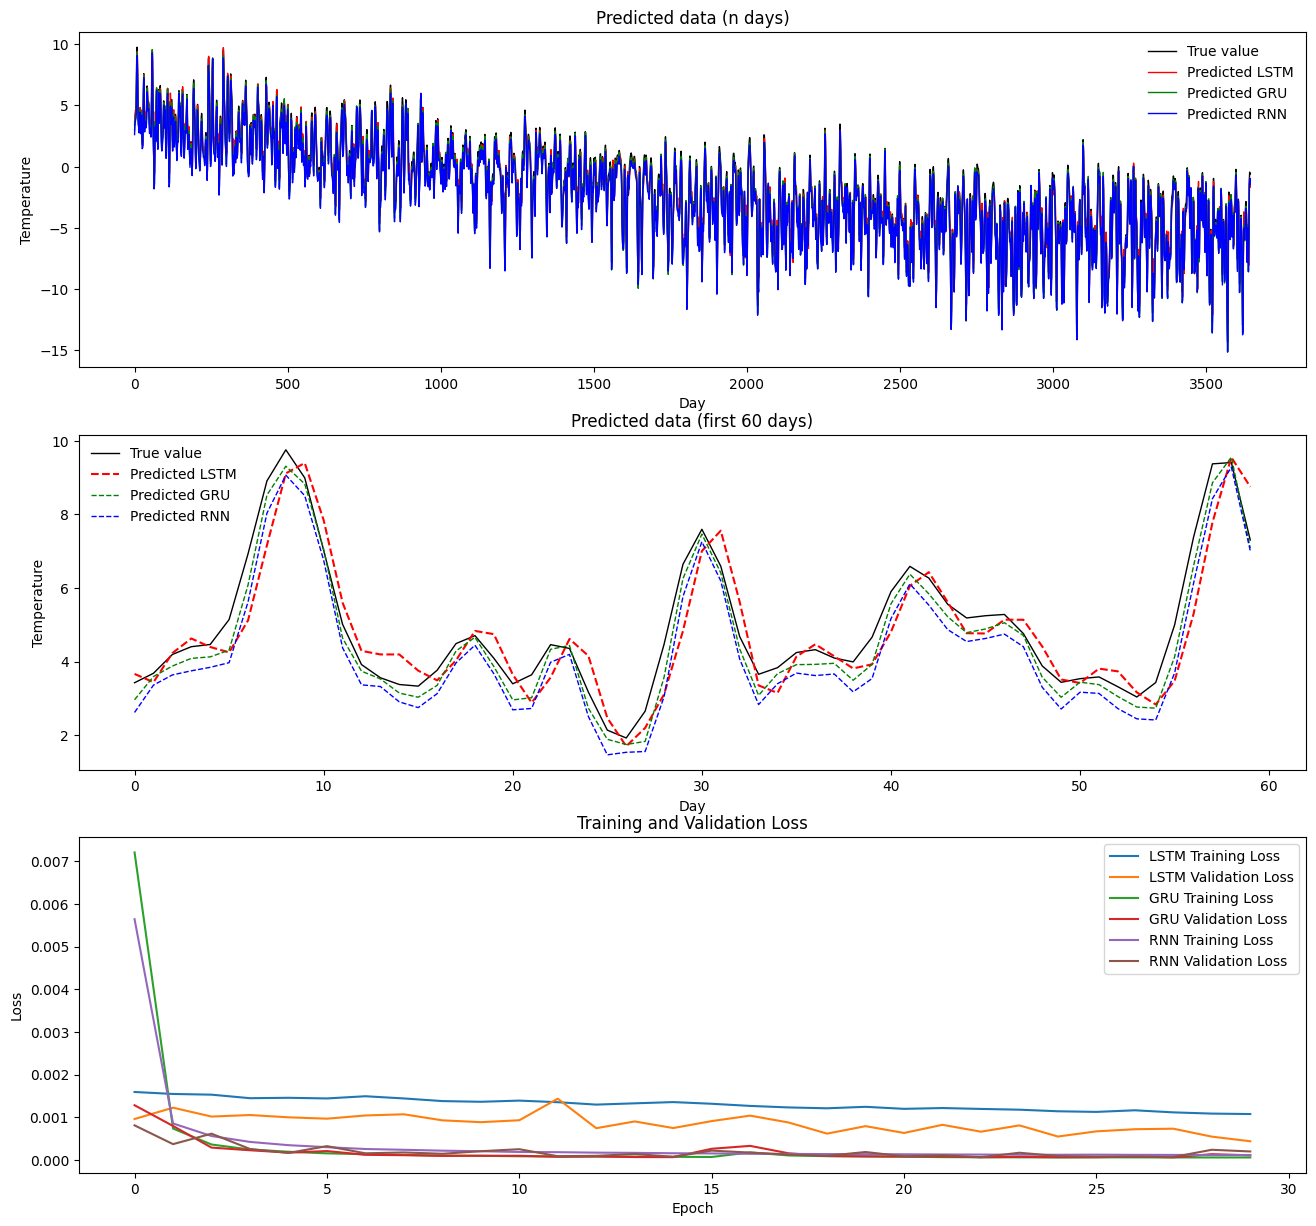

In [ ]:
fig, axes = plt.subplots(figsize=[13, 12])
fig.tight_layout ()
plt.subplot(3, 1, 1)
plt.plot(scaler.inverse_transform(y_test), color='black', linewidth=1, label='True value')
plt.plot(y_pred_lstm, color='red',  linewidth=1, label='Predicted LSTM')
plt.plot(y_pred_gru, color='green',  linewidth=1, label='Predicted GRU')
plt.plot(y_pred_rnn, color='blue',  linewidth=1, label='Predicted RNN')
plt.legend(frameon=False)
plt.ylabel("Temperature")
plt.xlabel("Day")
plt.title("Predicted data (n days)")

plt.subplot(3, 1, 2)
plt.plot(scaler.inverse_transform(y_test)[0:60], color='black', linewidth=1, label='True value')
plt.plot(y_pred_lstm[0:60], color='red', label='Predicted LSTM',linestyle='dashed')
plt.plot(y_pred_gru[0:60], color='green',  linewidth=1, label='Predicted GRU',linestyle='dashed')
plt.plot(y_pred_rnn[0:60], color='blue',  linewidth=1, label='Predicted RNN',linestyle='dashed')
plt.legend(frameon=False)
plt.ylabel("Temperature")
plt.xlabel("Day")
plt.title("Predicted data (first 60 days)")

plt.subplot(3, 1, 3)
plt.plot(history_lstm.history['loss'], label='LSTM Training Loss')
plt.plot(history_lstm.history['val_loss'], label='LSTM Validation Loss')
plt.plot(history_gru.history['loss'], label='GRU Training Loss')
plt.plot(history_gru.history['val_loss'], label='GRU Validation Loss')
plt.plot(history_rnn.history['loss'], label='RNN Training Loss')
plt.plot(history_rnn.history['val_loss'], label='RNN Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

Вывод: наилучший результат показала модель двунаправленная LSTM с наименьшой ошибкой в прогнозировании.